In [ ]:
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install scikit-image
!pip install scikit-learn
!pip install scipy
!pip install pywavelets
!pip install torch
!pip install torchvision
!pip install tqdm
!pip install tifffile
!pip install patchify
!pip install pillow
!pip install pytorch-toolbelt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
import os
import zipfile

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from skimage import data
from skimage.filters import threshold_multiotsu
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage import img_as_ubyte
from skimage import io, color

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from scipy.fft import fft, fftfreq
from scipy.ndimage import *
from scipy.stats import pearsonr

import pywt

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm
import tifffile as tiff

from patchify import patchify
from PIL import Image

import prepare_utils

# Uploads Data

In [ ]:
input_image = Image.open('rec_00400.tif')

input_matrix = np.array(input_image)
input_matrix.shape

(2615, 2615)

In [ ]:
res = Image.open('Label_400_final.tif')

output_martix = np.array(res)
output_martix.shape

(2615, 2615)

# Preprocess Data

## Augmentation

In [ ]:
def image_rotate(image, d_a):
    angles = np.arange(0, 350 + d_a, d_a)
    r_img_list = []
    for angle in angles:
        r_img = rotate(image, angle, mode='reflect', reshape=False, order=0)
        r_img_list.append(r_img)
    return r_img_list
def data_rotate(data, d_a):
    data_list = []
    for i in tqdm(range(data.shape[0])):
        data_j_list = []
        for j in range(data.shape[1]):
            data_j_list += image_rotate(data[i, j], d_a)
        data_list += data_j_list
    rotated_data = np.asarray(data_list)
    return rotated_data

In [ ]:
test_data_list = []

data_cut_array = patchify(input_matrix, (128, 128), step=128)

label_cut_array = patchify(output_martix, (128, 128), step=128)

In [ ]:
label_cut_array.shape

(20, 20, 128, 128)

In [ ]:
# rotate
rotated_cut_images = data_rotate(data_cut_array, d_a=10)

rotated_label_images = data_rotate(label_cut_array, d_a=10)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
rotated_label_images.shape

(14400, 128, 128)

In [ ]:
# removing black img

def process_and_filter_images(data_array, label_array, threshold=0.6):
    valid_data_arrays = []
    valid_label_arrays = []

    for d_ind, _ in enumerate(data_array):
        data_img = data_array[d_ind]
        label_img = label_array[d_ind]

        black_pixels = np.sum(data_img == 0)
        all_pixels = data_img.size
        black_pixel_percentage = black_pixels / all_pixels

        if black_pixel_percentage <= threshold:
            valid_data_arrays.append(data_img)
            valid_label_arrays.append(label_img)
    return np.array(valid_data_arrays), np.array(valid_label_arrays)

In [ ]:
print(rotated_cut_images.shape)
rotated_cut_images, rotated_label_images = process_and_filter_images(rotated_cut_images, rotated_label_images)
print(rotated_cut_images.shape)

(14400, 128, 128)
(11352, 128, 128)


In [ ]:
X = np.stack((rotated_cut_images, rotated_cut_images), axis=3)

X_train, X_test, y_train, y_test = train_test_split(X, rotated_label_images, test_size=0.10, random_state=42)

In [ ]:
print(X_train.shape)
X.shape

(10216, 128, 128, 2)


(11352, 128, 128, 2)

# AI models

## Fully CNN

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation):
        super(ConvBlock, self).__init__()
        self.conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=1)
        self.batch_norm_layer = nn.BatchNorm2d(out_channels)
        self.activation_layer = nn.ReLU() if activation == 'relu' else nn.PReLU()
        self.dropout_layer = nn.Dropout2d(p=0.2)

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.batch_norm_layer(x)
        x = self.activation_layer(x)
        x = self.dropout_layer(x)
        return x

class FullyCNN(nn.Module):
    def __init__(self, in_channels, pretrained_weights=None):
        super(FullyCNN, self).__init__()

        self.conv_layers_3x3 = nn.ModuleList([ConvBlock(in_channels, 32, kernel_size=3, activation='relu')])

        self.n = 8
        for i in range(self.n):
            self.conv_layers_3x3.append(ConvBlock(32, 32, kernel_size=3, activation='relu'))

        self.output_layer = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        for conv_layer in self.conv_layers_3x3:
            x = conv_layer(x)
        x = self.output_layer(x)
        return x

# Train models

In [ ]:
try:
  X_tensor = torch.from_numpy(X_train).float()
  y_tensor = torch.from_numpy(y_train).float()
except Exception as e:
  X_tensor = torch.from_numpy(X_train.astype(np.float32))
  y_tensor = torch.from_numpy(y_train.astype(np.float32))

dataset = TensorDataset(X_tensor, y_tensor)

batch_size = 32
train_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Usefull function

In [ ]:
def calculate_accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1)
    correct_pixels = torch.eq(predictions, targets).sum().item()
    total_pixels = targets.numel()
    accuracy = correct_pixels / total_pixels
    return accuracy

def calculate_iou(predictions, targets):
    intersection = torch.logical_and(targets, predictions).sum().item()
    union = torch.logical_or(targets, predictions).sum().item()
    iou = intersection / union
    return iou

def log_metrics(phase, epoch, loss, accuracy, iou):
    print(f'{phase}_loss', loss, epoch)
    print(f'{phase}_accuracy', accuracy, epoch)
    print(f'{phase}_iou', iou, epoch)

def train(model, train_loader, criterion, optimizer, epoch, log_metrics, save_folder):
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    total_iou = 0.0

    for ep in tqdm(range(1, epoch+1)):
      for (inputs, targets) in tqdm(train_loader):
          inputs = inputs.unsqueeze(0).permute(0, 3, 1, 2)
          targets = targets.unsqueeze(0).unsqueeze(-1).permute(0, 3, 1, 2)

          # print(inputs.shape)
          # print(targets.shape)

          optimizer.zero_grad()
          outputs = model(inputs)

          loss = criterion(outputs[0, 0, :, :], targets[0, 0, :, :])
          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          accuracy = calculate_accuracy(outputs, targets)
          total_accuracy += accuracy
          iou = calculate_iou(outputs, targets)
          total_iou += iou

          # progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': accuracy, 'IOU': iou})

    average_loss = total_loss / len(train_loader)
    average_accuracy = total_accuracy / len(train_loader)
    average_iou = total_iou / len(train_loader)

    log_metrics('train', epoch, average_loss, average_accuracy, average_iou)

    # Save the model if it has the best performance so far
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    save_path = f"{save_folder}/model_epoch_{epoch}.pt"
    torch.save(model.state_dict(), save_path)

    return save_path

def validate(model, val_loader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    total_iou = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            accuracy = calculate_accuracy(outputs, targets)
            total_accuracy += accuracy
            iou = calculate_iou(outputs, targets)
            total_iou += iou

    average_loss = total_loss / len(val_loader)
    average_accuracy = total_accuracy / len(val_loader)
    average_iou = total_iou / len(val_loader)

    log_metrics('val', epoch, average_loss, average_accuracy, average_iou)


In [ ]:
def visualize_random_sample(model, train_loader):
    random_index = np.random.randint(len(train_loader.dataset))
    sample = train_loader.dataset[random_index]

    # print(sample)
    input_image, target_mask = sample[0], sample[1]

    # Add batch dimension and adjust dimensions
    input_image = input_image.unsqueeze(0).permute(0, 3, 1, 2)
    target_mask = target_mask.unsqueeze(0).unsqueeze(-1).permute(0, 3, 1, 2)

    # Forward pass to get model predictions
    model.eval()
    with torch.no_grad():
        predicted_mask = model(input_image)

    # Plot the original image, ground truth mask, and predicted mask
    print(random_index)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image[0, 0, :, :])
    plt.title('Original Image')
    plt.axis('off')

    print(target_mask.shape)
    plt.subplot(1, 3, 2)
    plt.imshow(target_mask[0, 0, :, :], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    print(predicted_mask.shape)
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

In [ ]:
def visualize_custom_sample(model, train_loader, index=3413):
    sample = train_loader.dataset[index]

    # print(sample)
    input_image, target_mask = sample[0], sample[1]

    # Add batch dimension and adjust dimensions
    input_image = input_image.unsqueeze(0).permute(0, 3, 1, 2)
    target_mask = target_mask.unsqueeze(0).unsqueeze(-1).permute(0, 3, 1, 2)

    # Forward pass to get model predictions
    model.eval()
    with torch.no_grad():
        predicted_mask = model(input_image)

    # Plot the original image, ground truth mask, and predicted mask
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image[0, 0, :, :])
    plt.title('Original Image')
    plt.axis('off')

    print(target_mask.shape)
    plt.subplot(1, 3, 2)
    plt.imshow(target_mask[0, 0, :, :])
    plt.title('Ground Truth Mask')
    plt.axis('off')

    print(predicted_mask.shape)
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze())
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

In [ ]:
def train_lovaz(model, train_loader, criterion, optimizer, epoch, log_metrics, save_folder):
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    total_iou = 0.0

    for ep in tqdm(range(1, epoch+1)):
      for (inputs, targets) in tqdm(train_loader):
          inputs = inputs.unsqueeze(0).permute(0, 3, 1, 2)
          targets = targets.unsqueeze(0).unsqueeze(-1).permute(0, 3, 1, 2)

          optimizer.zero_grad()
          outputs = model(inputs)

          print(f"Output shape: {outputs[0, 0, :, :].shape}, Target shape: {targets[0, 0, :, :].shape}")
          loss = criterion(outputs[:, :, :, :], targets[:, :, :, :])
          print(f'{loss}')
          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          accuracy = calculate_accuracy(outputs, targets)
          total_accuracy += accuracy
          iou = calculate_iou(outputs, targets)
          total_iou += iou

    average_loss = total_loss / len(train_loader)
    average_accuracy = total_accuracy / len(train_loader)
    average_iou = total_iou / len(train_loader)

    log_metrics('train', epoch, average_loss, average_accuracy, average_iou)

    # Save the model if it has the best performance so far
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    save_path = f"{save_folder}/model_epoch_{epoch}.pt"
    torch.save(model.state_dict(), save_path)

    return save_path

## Fully CNN - DynamicDice - import pytorch_toolbelt.losses as L

### IOU+Dice

In [ ]:
def generalIoU(pred, target):
    intersection = torch.sum(torch.min(pred, target))
    union = torch.sum(torch.max(pred, target))
    iou = intersection / union
    return iou

def diceIoU(pred, target):
    dice = (2 * torch.sum(torch.min(pred, target))) / (torch.sum(pred) + torch.sum(target))
    iou = dice / (2 - dice)  # Convert Dice to IoU
    return iou

def completeIoU(pred, target):
    intersection = torch.sum(torch.min(pred, target))
    union = torch.sum(torch.max(pred, target))
    iou = intersection / union

    center_pred = (pred[:, 0] + pred[:, 2]) / 2, (pred[:, 1] + pred[:, 3]) / 2
    center_target = (target[:, 0] + target[:, 2]) / 2, (target[:, 1] + target[:, 3]) / 2

    center_distance = torch.sqrt((center_pred[0] - center_target[0])**2 + (center_pred[1] - center_target[1])**2)
    diagonal = torch.sqrt((torch.max(pred[:, 2], target[:, 2]) - torch.min(pred[:, 0], target[:, 0]))**2 +
                         (torch.max(pred[:, 3], target[:, 3]) - torch.min(pred[:, 1], target[:, 1]))**2)

    cIoU = iou - (center_distance**2) / diagonal**2
    return cIoU


def criterion(pred, target):
    dice_iou_loss = 1 - (diceIoU(pred, target) + completeIoU(pred, target))
    return torch.mean(dice_iou_loss)

model = FullyCNN(in_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
log_metrics = lambda *args: print(args)

train(model, dataset, criterion, optimizer, EPOCH, log_metrics, 'fully_cnn_custom_metric')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10216 [00:00<?, ?it/s]

  0%|          | 0/10216 [00:00<?, ?it/s]

In [ ]:
%%time
visualize_custom_sample(model, train_loader)

### Jokart

In [ ]:
class JokartLoss(nn.Module):
    def __init__(self):
        super(JokartLoss, self).__init__()

    def forward(self, predicted_mask, target_mask):
        assert predicted_mask.shape == target_mask.shape, "Shape mismatch between predicted_mask and target_mask"

        intersection = torch.sum(predicted_mask * target_mask)
        union = torch.sum(predicted_mask) + torch.sum(target_mask) - intersection

        jokart_loss = 1 - (2 * intersection + 1) / (union + 1)

        return jokart_loss

In [ ]:
criterion = JokartLoss()

EPOCH = 3

model_fcnn = FCNN(2, 1)
optimizer = torch.optim.Adam(model_fcnn.parameters(), lr=0.001)
log_metrics = lambda *args: print(args)

train(model_fcnn, dataset, criterion, optimizer, EPOCH, log_metrics, 'fcnn_cut_black_jokart')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10216 [00:00<?, ?it/s]

  0%|          | 0/10216 [00:00<?, ?it/s]

  0%|          | 0/10216 [00:00<?, ?it/s]

('train', 3, 61.52643672351783, 0.0, 3.0)


'fcnn_cut_black_jokart/model_epoch_3.pt'

torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])


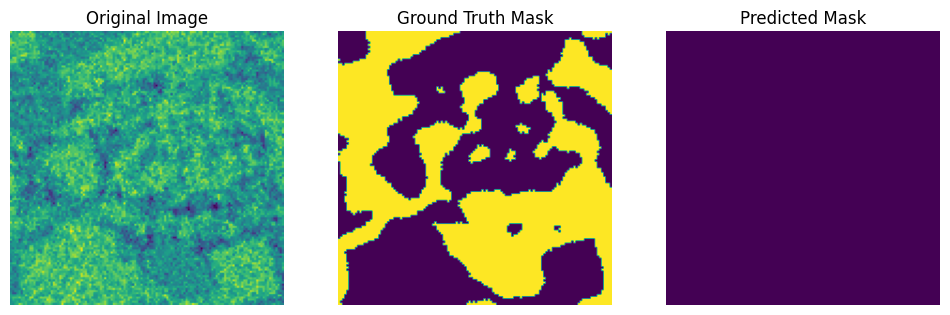

CPU times: user 410 ms, sys: 94.7 ms, total: 504 ms
Wall time: 412 ms


In [ ]:
%%time
visualize_custom_sample(model_fcnn, train_loader)

### MSE

In [ ]:
criterion = nn.MSELoss()

EPOCH = 3

model_fcnn = FCNN(2, 1)
optimizer = torch.optim.Adam(model_fcnn.parameters(), lr=0.001)
log_metrics = lambda *args: print(args)

train(model_fcnn, dataset, criterion, optimizer, EPOCH, log_metrics, 'fcnn_cut_black_mae')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10216 [00:00<?, ?it/s]

  0%|          | 0/10216 [00:00<?, ?it/s]

  0%|          | 0/10216 [00:00<?, ?it/s]

('train', 3, 2.240954756986041, 0.0, 3.0)


'fcnn_cut_black_mae/model_epoch_3.pt'

torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])


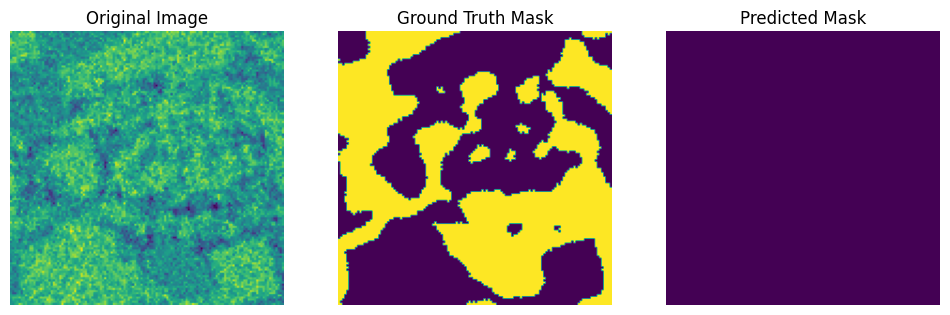

CPU times: user 924 ms, sys: 36.9 ms, total: 961 ms
Wall time: 1.21 s


In [ ]:
%%time
visualize_custom_sample(model_fcnn, train_loader)